In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import pandas as pd

### States

In [3]:
zero  = np.array([[1], [0], [0], [0], [0], [0]],dtype=complex)
one   = np.array([[0], [1], [0], [0], [0], [0]],dtype=complex)
two   = np.array([[0], [0], [1], [0], [0], [0]],dtype=complex)
three = np.array([[0], [0], [0], [1], [0], [0]],dtype=complex)
four  = np.array([[0], [0], [0], [0], [1], [0]],dtype=complex)
five  = np.array([[0], [0], [0], [0], [0], [1]],dtype=complex)

### Permutations

In [4]:
Id = zero@zero.T + one@one.T + two@two.T + \
     three@three.T + four@four.T + five@five.T
## Permutations for two species of fermions
SN_f = - zero@zero.T - one@one.T + five@two.T \
     +four@three.T+three@four.T+ two@five.T

SS_f =  -zero@zero.T - one@one.T + five@three.T \
     +four@two.T+two@four.T+ three@five.T

SE_f =  -two@two.T - three@three.T + five@one.T \
     +four@zero.T+zero@four.T+ one@five.T

SW_f = - two@two.T - three@three.T + five@zero.T \
     +four@one.T+one@four.T+ zero@five.T

## Permutations for two species of Bosons
SN_b =  zero@zero.T + one@one.T + five@two.T \
     +four@three.T+three@four.T+ two@five.T

SS_b =  zero@zero.T + one@one.T + five@three.T \
     +four@two.T+two@four.T+ three@five.T

SE_b =  two@two.T + three@three.T + five@one.T \
     +four@zero.T+zero@four.T+ one@five.T

SW_b =  two@two.T + three@three.T + five@zero.T \
     +four@one.T+one@four.T+ zero@five.T

## Permutations for blue (bottom) boson and green (top) of fermion
SN_m =  -zero@zero.T + one@one.T + five@two.T \
     +four@three.T+three@four.T+ two@five.T

SS_m =  zero@zero.T - one@one.T + five@three.T \
     +four@two.T+two@four.T+ three@five.T

SE_m =  -two@two.T + three@three.T + five@one.T \
     +four@zero.T+zero@four.T+ one@five.T

SW_m =  two@two.T - three@three.T + five@zero.T \
     +four@one.T+one@four.T+ zero@five.T

### Set of allowed moves for each agent
We will use the fermionic puzzle which is chosen arbitraily. The underlying particle structure does not meaningfully change the solving strategies to our knowledge.

In [5]:
Perms = [SN_f,SS_f,SE_f,SN_f]
SQRT_SWAP = [(Id + 1j*P)/np.sqrt(2) for P in Perms]
# Classical agent
CS = Perms

# Quantum agent's moves
QS = []
for move in SQRT_SWAP:
    QS.append(move)
    QS.append(np.transpose(np.conj(move)))
    
# Mixed agents moves 
MS = []
for move in SQRT_SWAP:
    MS.append(move)
    MS.append(np.transpose(np.conj(move)))
for move in Perms:
    MS.append(move)


## Scrambling
Scrambles are sqeunces of half swaps applied to the solved state. Here we generate a number of random scrambles with some constraintes on the minimum and maximum length of the scramble. 

In [6]:
## Generate a bunch of scrambles
Num_scrambles = 2000
min_length = 200
max_length = 500
Scrambles = []
for i in range(Num_scrambles):
    l = random.randint(min_length,max_length)
    move_list = random.choices(QS,k=l)
    state = zero
    for move in move_list:
        state = move @ state
    Scrambles.append(state)

# Rules

At first we will consider the situation in which the puzzle is reset after a measurement failure. After that we will consider a simplified version where each solver is only given one puzzle and only has one chance to measure it. 

## Finding performance of optimal strategy for reseting puzzle
The optimal strategy requires us to iterativly find all states that are up to $n$ moves away from the scrambled state. A target state is 1 move away from the scramble if a single actions from the solvers set of actions can transform the scrambled state into the target state. A state is 2 moves away from the scramble if the shortest possible set of actions from the solver to go between the scramble and target state is 2 moves.

Implementing this requires a breadth first search approach, that keeps track of which states have been seen and which have not. This search is implemented using a hashing of the state keeping 8 significant digits and canonicallizing the states. The optimal_search function then implements the search that will either continue until the optimal state is found, or some max_depth constraint is reached.

The function takes in a scramble a set of solving actions and optionally a set of costs for applying solving actions and measureing.

In [22]:
## Helper functions to generate sets of reachable states

def hash_func(state):
    string = ''
    temp = np.round(canonical_phase(state),8)
    for coeff in temp:
        if np.real(coeff) == 0 :
            string += '[0.]'
        else:
            string +=   str(np.real(coeff))
        if np.imag(coeff) == 0:
            string += '[0.]'
        else:
            string += str(np.imag(coeff))
        
    return string

def canonical_phase(state):
    #phase choosen so that the first nonzero element is positive
    for coeff in state:
        if not math.isclose(np.abs(coeff),0):
            phase = np.angle(coeff)
            break
    return state / np.exp(1j*phase)

def GeoMean(state,m):
    P = np.abs(state[0])**2
    return m/P

In [581]:
def optimal_search(scramble,move_set,Cost=[1,1],max_depth = 100):
    #Inputs: 
    #      scramble: initial state of a scramble
    #.     move_set: list of allowed actions to apply to the scramble
    #.     Cost: a list of costs, Cost[0] is the cost of moving and Cost[1] is the cost of measureing
    #.     max_depth: a finite depth to terminate the search for an optimal state after
    #Outputs:
    #.      best_depth: the depth parameter, M, of the optimal state
    #.      best_prob: the probabilty parameter, P, of the optimal state
    move_cost = Cost[0]
    meas_cost = Cost[1]
    group = {hash_func(scramble):scramble}
    new_elems = group
    depth = 0
    best  = GeoMean(scramble,depth+meas_cost)
    best_depth = depth+meas_cost
    best_prob = 1/best*best_depth
    while((depth+meas_cost)<min(best,max_depth)):
        current_group = new_elems.copy()
        new_elems = {}
        for g in move_set:
            # iterate through the group
            for key in current_group: 
                state = g@current_group[key]
                hashed = hash_func(state)
                if not (hashed in group):
                    new_elems.update({hashed:state}) 
                    group.update({hashed:state})
                    if(GeoMean(state,depth+move_cost+meas_cost)< best):
                        best = GeoMean(state,depth+move_cost+meas_cost)
                        best_depth = depth+move_cost+meas_cost
                        best_prob = 1/best*best_depth
        depth += move_cost
    return [best_depth,best_prob]

def Sample_scrambles_opt(Scrambles,move_set,Cost,max_depth=100):
    #Inputs: 
    #      Scrambles: list of scrambled states
    #.     move_set: list of allowed actions to apply to the scramble
    #.     Cost: a list of costs, Cost[0] is the cost of moving and Cost[1] is the cost of measureing
    #.     max_depth: a finite depth to terminate the search for an optimal state after
    #Outputs: 
    #.     M_samples: An np array of integer depths, M, from the optimal state from each scramble
    #.     P_samples: An np array of probabilites, P, from the optimal state of each scramble
    P_samples = []
    M_samples = []
    for i,scramble in enumerate(Scrambles):
        [M,P] = optimal_search(scramble,move_set,Cost,max_depth)
        P_samples.append(P[0])
        M_samples.append(M)
        if(i/len(Scrambles)%.1< (i-1)/len(Scrambles)%.1):
            print("Progress:", i/len(Scrambles))
    return [np.array(M_samples),np.array(P_samples[:][:])]


In [700]:
Costs = [1,1]

In [736]:
dataQ = Sample_scrambles_opt(Scrambles,QS,Costs,max_depth = 9)

Progress: 0.0
Progress: 0.1
Progress: 0.2
Progress: 0.3005
Progress: 0.4
Progress: 0.5005
Progress: 0.6005
Progress: 0.7005
Progress: 0.8
Progress: 0.9005


In [737]:
dataC = Sample_scrambles_opt(Scrambles,CS,Costs)

Progress: 0.0
Progress: 0.1
Progress: 0.2
Progress: 0.3005
Progress: 0.4
Progress: 0.5005
Progress: 0.6005
Progress: 0.7005
Progress: 0.8
Progress: 0.9005


In [738]:
dbfile = open('Data/QuantumOptimal_WithSwaps_2000', 'ab')
     
pickle.dump(dataQ, dbfile) 
dbfile.close()
                  
dbfile = open('Data/ClassicalOptimal_WithSwaps_2000', 'ab')
     
pickle.dump(dataC, dbfile) 
dbfile.close()



### Analyzing the data
In the case where the puzzle is reset the number of moves until the puzzle is solved follows a gemoetric distribution. 
$$
N_\varphi = (M_\varphi+1)\text{Geo}(P_\varphi)
$$
where $M_\varphi$ is the distance from the scramble to the optimal state $\varphi$ and $P_\varphi$ is the squared overlap of the optimal state with the solved state $|\langle\varphi|\text{solved}\rangle|^2$.
In order to find the true performance of each solver we descretely sample the scramble space to build a distribution $Z(M,P)$ that describes how the parameters of the geometric distribution are distributied among random scrambles of the puzzle. We can finally define $G(n|M,P)$ to be the PDF that describes the distribution of the number of moves to solved $n$ given the scramble based parameters $M,P$.

In the limit of infinite sampling the the distribution of move count independent of scrambles becomes
$$
G(n) = \int_\Omega G(n|M,P) d\mu(\Omega(M,P)) = \sum_{M=1}^\infty \int_0^1 dP G(n|M,P)Z(M,P)
$$



In [10]:
dbfile = open('Data/QuantumOptimal_WithSwaps_2000', 'rb')    
dataQ = pickle.load(dbfile)
dbfile.close()

dbfile = open('Data/ClassicalOptimal_WithSwaps_2000', 'rb')    
dataC = pickle.load(dbfile)
dbfile.close()

In [21]:

#G(n|M,P)
def conditionalGeo(n,M,P):
    #Inputs:
    #.     n: integer move counnt
    #.     M: integer depth of optimal state
    #      P: probability of sucess with optimal state
    #Outputs: 
    #.     G(n|M,P)
    if (n/M == n//M):
        return (1-P)**(n//M-1)*P
    return 0

def Prob(x,Mvals,Pvals,Z):
    #Inputs
    psum = 0
    for i,m in enumerate(Mvals):
        for j,p in enumerate(Pvals):
            psum += conditionalGeo(x,m,p) * Z[j,i]
    return psum

In [27]:
dfQ = pd.DataFrame({'M': dataQ[0],'P':dataQ[1]})
dfC = pd.DataFrame({'M': dataC[0],'P':dataC[1]})
depth = 10
Num_scrambles = len(dataQ[0])
Costs = [1,1]
# choosing number of bins according to Scott's Rule
std = np.std(dataQ[1])
N = int(np.round(Num_scrambles**(1/3)/(3.49*std)))
# Discretizing the sample space
Mvals = np.linspace(Costs[1],depth*Costs[0]+Costs[1],depth*Costs[0]+1)
Pvals = np.linspace(0,1,N)

dfQ = dfQ.sort_values(by=['M','P'])
dfC = dfC.sort_values(by=['M','P'])
countsQ = np.zeros([len(Pvals),depth+1])
countsC = np.zeros([len(Pvals),depth+1])

for j,M in enumerate(Mvals):
    margQ = dfQ.loc[dfQ['M']==M].get('P')
    margC = dfC.loc[dfC['M']==M].get('P')
    for i,p in enumerate(Pvals):
        for data in margQ:
            if (p<=1):
                if (data > p and data<=Pvals[i+1]):
                    countsQ[i,j]+= 1
        for data in margC:
            if (p<=1):
                if (data > p and data<=Pvals[i+1]):
                    countsC[i,j]+= 1
ZQ = countsQ/Num_scrambles
ZC = countsC/Num_scrambles

distQ = []
distC = []
meanQ = 0
meanC = 0

nvals = range(1,100)
for n in nvals:
    P_x_Q = Prob(n,Mvals,Pvals,ZQ)
    P_x_C = Prob(n,Mvals,Pvals,ZC)
    distQ.append(P_x_Q)
    distC.append(P_x_C)
    meanQ += x*P_x_Q
    meanC += x*P_x_C
print(meanQ,meanC)
print(sum(distQ),sum(distC))

5.4524528009951645 6.627480530491385
0.9999985555151389 0.9999130636220372


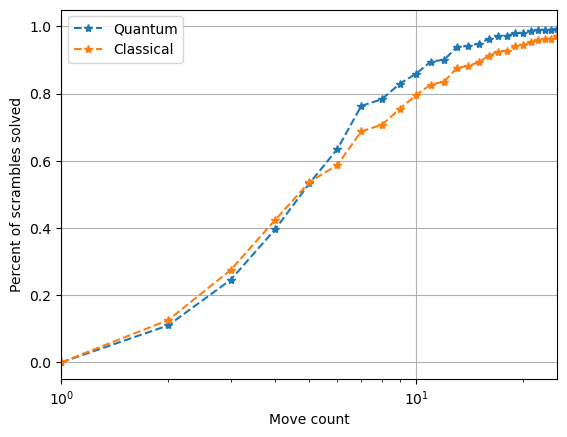

In [32]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.clf()
plt.semilogx(xvals,[sum(distQ[0:n]) for n in range(len(distQ))],'--*')
plt.semilogx(xvals,[sum(distC[0:n]) for n in range(len(distC))],'--*')
#plt.bar([x+.5 for x in xvals],distC,width=.4,)
plt.xlim([1,25])
#plt.plot([meanQ],[0.59],'o',color="blue")
#plt.plot([meanC],[.67],'o',color="orange")
plt.legend(["Quantum","Classical"])
plt.ylabel("Percent of scrambles solved")
plt.xlabel("Move count")
plt.grid()
plt.show()
# plt.plot([np.median(dataQ[0]/dataQ[1]),np.median(dataQ[0]/dataQ[1])],[0,1])
# plt.plot([0,10],[.5,.5])
# plt.plot([np.median(dataC[0]/dataC[1]),np.median(dataC[0]/dataC[1])],[0,1])
plt.savefig("./SolvingCDF_noswap.pdf",format="pdf")

## Scramble Parameter Distributions

<Figure size 640x480 with 0 Axes>

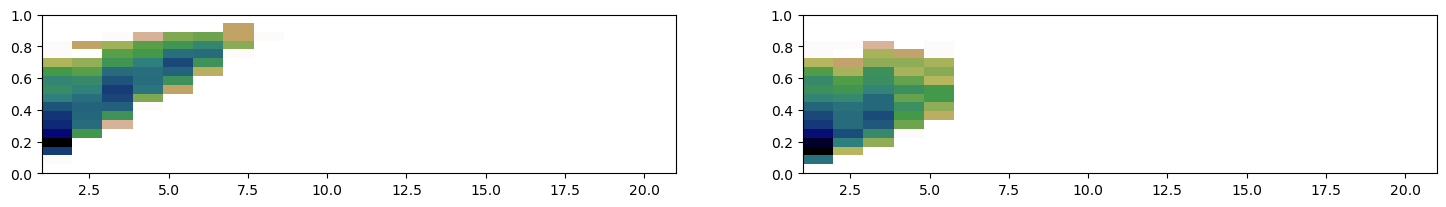

In [33]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].imshow(ZQ, cmap=plt.cm.gist_earth_r,
          extent=[1, depth+1, 0, 1],origin='lower',aspect = 5,norm=LogNorm())
ax[1].imshow(ZC, cmap=plt.cm.gist_earth_r,
          extent=[1, depth+1, 0, 1],origin='lower',aspect = 5,norm=LogNorm())
plt.show()

In [12]:
## Generate a bunch of scrambles
Num_scrambles = 2000
min_length = 200
max_length = 200
Scrambles = []
for i in range(Num_scrambles):
    l = random.randint(min_length,max_length)
    move_list = random.choices(QS,k=l)
    state = zero
    for move in move_list:
        state = move @ state
    Scrambles.append(state)

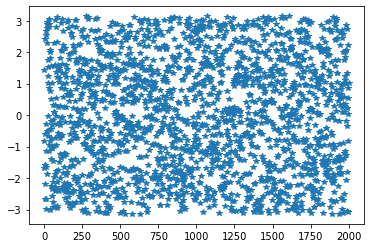

In [15]:
y = []
for scram in Scrambles:
    y.append((np.angle(scram[0]+scram[1]+scram[2]+scram[3]+scram[4]+scram[5]))[0])
fig, ax = plt.subplots()
ax.plot(y,'*')
plt.show()